## Regression of the energy response distribution

☢️☢️☢️ ***This can be a nice Qualification Task in egamma calibration*** ☢️☢️☢️

Here we will try not just to evaluate the best calibrated energy, but to get the distribution of the response. Basically we will get the distribution of $E_\text{raw}/E_\text{true}$ (and not only its best value).

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import scipy
tfd = tfp.distributions

2023-06-05 15:43:19.195122: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-05 15:43:19.302135: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Import data
Use the same inputs as in the previous simpler energy regression

In [2]:
df_train = pd.read_csv('http://rgw.fisica.unimi.it/TutorialML-AtlasItalia2022/train_electron_Et0-10_eta1.0-1.2_Eaccordion.csv?AWSAccessKeyId=M06HBTUGIKXVXYH1RES6&Signature=U%2BMJxVi5El1wxtCz%2B45VqLmUuok%3D&Expires=1828739034')
df_test = pd.read_csv('http://rgw.fisica.unimi.it/TutorialML-AtlasItalia2022/test_electron_Et0-10_eta1.0-1.2_Eaccordion.csv?AWSAccessKeyId=M06HBTUGIKXVXYH1RES6&Signature=YKG4lzc%2FI0%2BcJZRnQG350DnVVK4%3D&Expires=1828739085')

#df_train = pd.read_csv('train_electron_Et0-10_eta1.0-1.2_Eaccordion.csv')
#df_test = pd.read_csv('test_electron_Et0-10_eta1.0-1.2_Eaccordion.csv')

#df_train = df_train[(df_train['el_erawOverEtrue'] > 0.5) & (df_train['el_erawOverEtrue'] < 1.2)]
#df_test = df_test[(df_test['el_erawOverEtrue'] > 0.5) & (df_test['el_erawOverEtrue'] < 1.2)]

df_train['el_rawcl_Es1Over2'] = df_train['el_rawcl_Es1'] / df_train['el_rawcl_Es2']
df_test['el_rawcl_Es1Over2'] = df_test['el_rawcl_Es1'] / df_test['el_rawcl_Es2']

In [3]:
columns_X = ['el_rawcl_E', 'el_rawcl_Es1Over2', 'el_f0', 'el_cl_aeta', ]  # input variables
column_y = 'el_erawOverEtrue'

normalizer = tf.keras.layers.Normalization()
normalizer.adapt(np.array(df_train[columns_X]))

## Model

### Pdf to be used
We have to choose the type of the pdf to use. To be generic, use a mixture of normal distributions, e.g.

$$
  \sum_{i=1}^3 \alpha_i \times N[\mu_i, \sigma^2_i]
$$

The algorithm will learn the parameters (9 in this case) as a function of the input variables

In [4]:
event_shape = [1]  # the energy if 1D scalar quantity -> 1D pdf
num_components = 3 # number of component of the pdf mixture (3 gaussian)
params_size = tfp.layers.MixtureNormal.params_size(num_components, event_shape)
params_size  # number of parameter of the final pdf (3 fractions, 3 means, 3 variances)

9

In [112]:
pdf_template = tfp.layers.MixtureNormal(num_components, event_shape)
#tfp.layers.MixtureSameFamily(num_components, tfp.layers.IndependentNormal(event_shape))

def f(x):
    """ sort the first three values """
    x_front = x[:, :3]
    x_tail = x[:, 3:]
    x_front = tf.sort(x_front, axis=-1)
    return tf.concat([x_front, x_tail], axis=-1)

def f(x):
    """ output: x[0], x[0] + x[1], x[0] + x[2], x[3], x[4], ... """
    x_cumsum = tf.add(tf.math.abs(x), tf.expand_dims(x[:, 0], -1))
    x_front = tf.concat([x[:, :1], x_cumsum[:, 1:2], x_cumsum[:, 2:3]], axis=-1)
    x_tail = x[:, 3:]
    return tf.concat([x_front, x_tail], axis=-1)

model = tf.keras.Sequential([
    tf.keras.Input(shape=len(columns_X)),
    normalizer,    
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(params_size, activation=None),
    tf.keras.layers.Lambda(f),
    pdf_template,
])

tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [113]:
model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 4)                9         
 n)                                                              
                                                                 
 dense_105 (Dense)           (None, 256)               1280      
                                                                 
 dropout_70 (Dropout)        (None, 256)               0         
                                                                 
 dense_106 (Dense)           (None, 64)                16448     
                                                                 
 dropout_71 (Dropout)        (None, 64)                0         
                                                                 
 dense_107 (Dense)           (None, 9)                 585       
                                                     

## Define the loss
This time we will define manually the loss. We will use the negative log-likelihood

In [114]:
negloglik = lambda y, p_y: -p_y.log_prob(y)
# note: it would be better to add some regularization terms, constraining the parameters to don't be degenerate, ...

## Train

In [115]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss=negloglik)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(df_train[columns_X].values, df_train[column_y].values,
                    epochs=50, batch_size=1024, validation_split=0.2, callbacks=[callback])

Epoch 1/50
72/72 [==============================] - 1s 7ms/step - loss: 0.3713 - val_loss: -0.3950
Epoch 2/50
72/72 [==============================] - 0s 4ms/step - loss: -0.4029 - val_loss: -0.7938
Epoch 3/50
72/72 [==============================] - 0s 4ms/step - loss: -0.6516 - val_loss: -0.8653
Epoch 4/50
72/72 [==============================] - 0s 4ms/step - loss: -0.7409 - val_loss: -0.9466
Epoch 5/50
72/72 [==============================] - 0s 4ms/step - loss: -0.7942 - val_loss: -0.9596
Epoch 6/50
72/72 [==============================] - 0s 4ms/step - loss: -0.8411 - val_loss: -1.0120
Epoch 7/50
72/72 [==============================] - 0s 4ms/step - loss: -0.8705 - val_loss: -1.0269
Epoch 8/50
72/72 [==============================] - 0s 4ms/step - loss: -0.9009 - val_loss: -1.0067
Epoch 9/50
72/72 [==============================] - 0s 4ms/step - loss: -0.9207 - val_loss: -1.0415
Epoch 10/50
72/72 [==============================] - 0s 4ms/step - loss: -0.9417 - val_loss: -1.0488


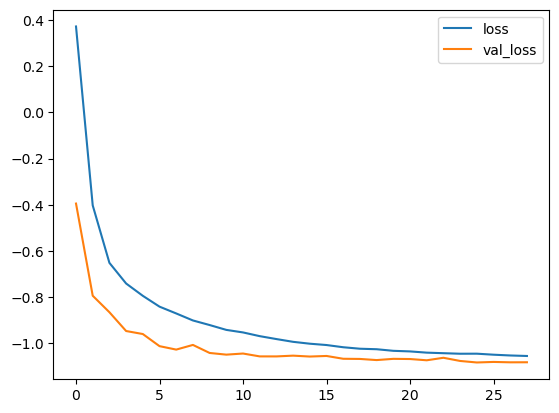

In [116]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

## Apply the model to the test sample
Note that the output is not a value, but a distribution

In [123]:
yhat = model(df_test[columns_X].values)  # note we are not using predict
yhat

<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[39200] event_shape=[1] dtype=float32>

## Plot the parameters of the estimated distributions

In [124]:
alphas = yhat.mixture_distribution.probs_parameter().numpy()
means = np.squeeze(yhat.components_distribution.mean().numpy())
stds = np.sqrt(np.squeeze(yhat.components_distribution.variance().numpy()))

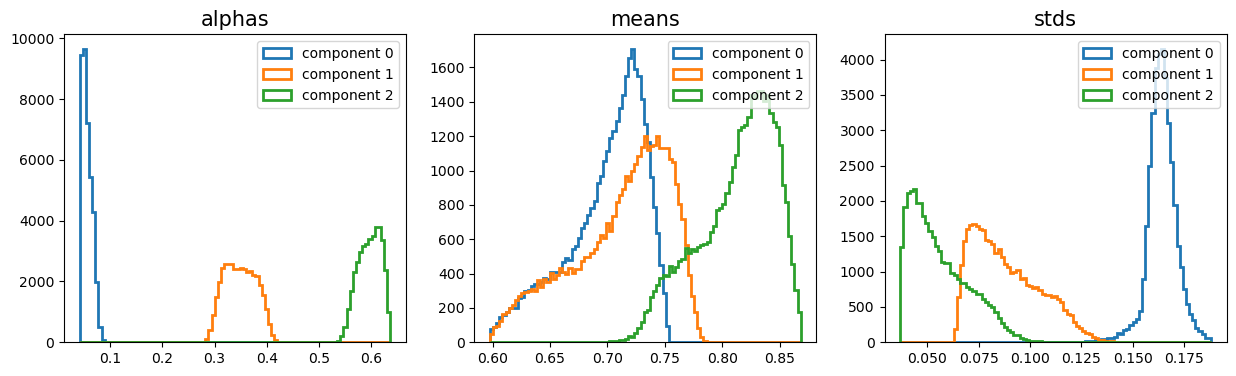

In [125]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
for ax, values, name in zip(axs.flat, (alphas, means, stds), ('alphas', 'means', 'stds')):
    m, M = np.quantile(values, (0.005, 0.999))
    for icomponent in range(num_components):
        ax.hist(values[:, icomponent], bins=np.linspace(m, M, 100),
                histtype='step', lw=2,
                label=f'component {icomponent}')
    ax.legend(loc=0)
    ax.set_title(name, fontsize=15)
plt.show()
fig.savefig('components.pdf', bbox_inches='tight')

Clearly one component is modelling the bulk, another the tail, another the outliers.

## Plot the mean and std of the estimated response
For each event we can estimated the resolution!

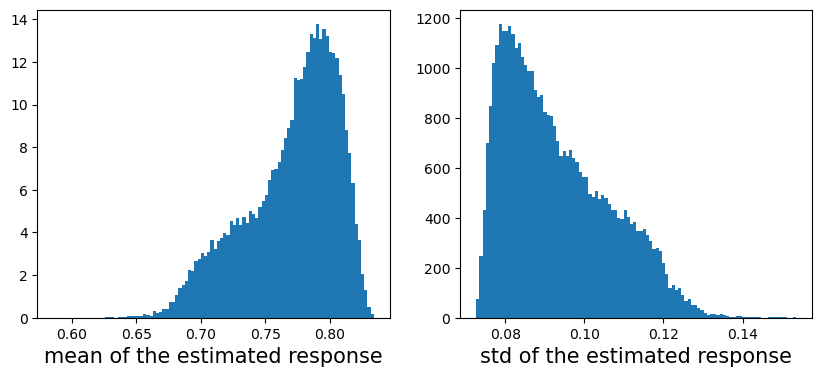

In [126]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

df_test['NN_mean'] = yhat.mean().numpy().flatten()
df_test['NN_std'] = np.sqrt(yhat.variance().numpy().flatten())


axs[0].hist(df_test['NN_mean'], bins=100, density=True)
axs[0].set_xlabel('mean of the estimated response', fontsize=15)

axs[1].hist(df_test['NN_std'], bins=100)
axs[1].set_xlabel('std of the estimated response', fontsize=15)
plt.show()
fig.savefig('response1.pdf', bbox_inches='tight')

## Respose of the first events
As example plot the response evaluated by the model for the fist events in the test sample.

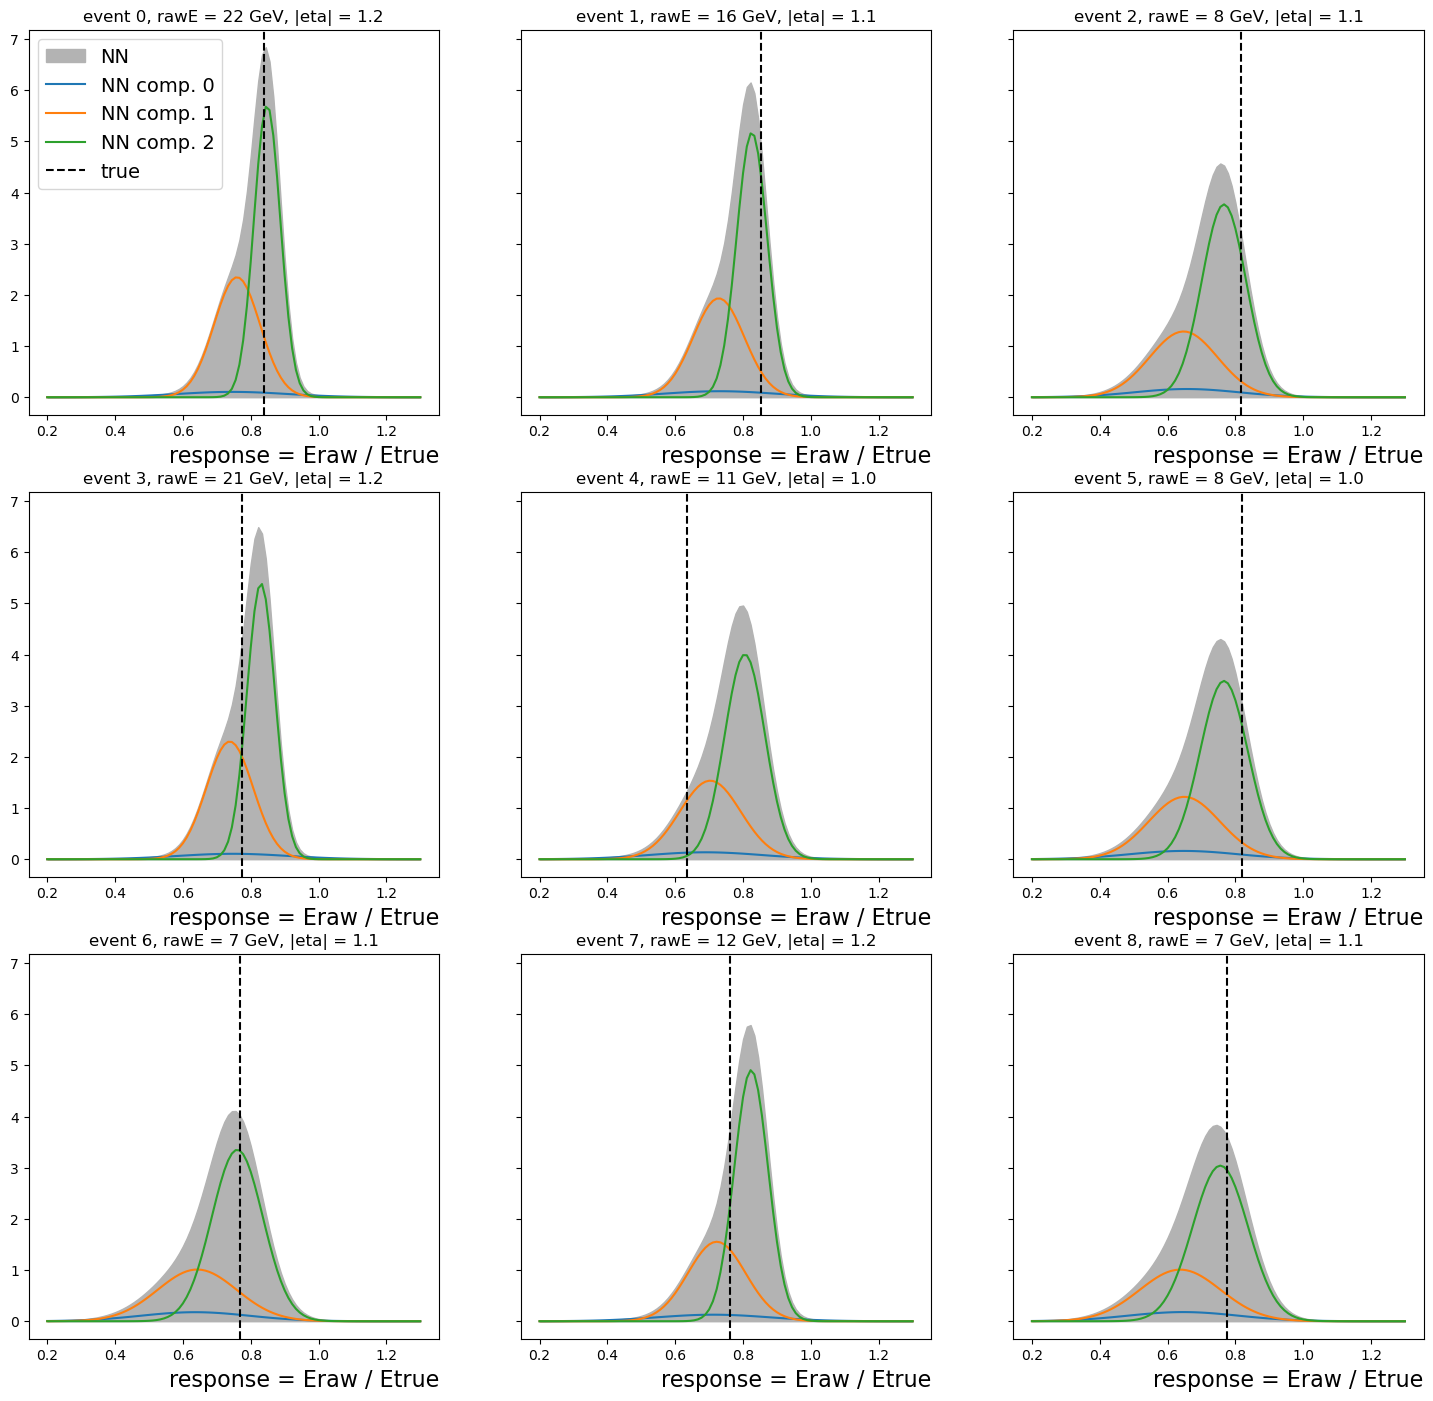

In [127]:
xspace = np.linspace(0.2, 1.3, 100)
fig, axs = plt.subplots(3, 3, figsize=(18, 17), sharey=True)


for idx, ax in enumerate(axs.flat):
    ys = scipy.stats.norm(means[idx], stds[idx]).pdf(np.tile(xspace, (3, 1)).T)
    ys = ys * alphas[idx]
    y = ys.sum(axis=1)
    ax.fill_between(xspace, y, color='0.7', label='NN')
    ax.plot(xspace, ys, label=[f'NN comp. {icomp}' for icomp in range(num_components)])
    ax.axvline(df_test.loc[idx, "el_erawOverEtrue"], color='k', ls='--', label='true')
    if idx == 0:
        ax.legend(loc=0, fontsize=14)
    ax.set_title('event %d, rawE = %.0f GeV, |eta| = %.1f' % (idx, df_test.loc[idx, "el_rawcl_E"] / 1E3, df_test.loc[idx, "el_cl_aeta"]), fontsize=12)
    ax.set_xlabel('response = Eraw / Etrue', fontsize=16, loc='right')
fig.savefig('example1.pdf', bbox_inches='tight')

Probably it would be good to introduce a regularization to very small components (maybe it is not needed?)

## Check the model response with the test sample
Evalue if the model is able to reproduce the distribution of the response from the test dataset

In [151]:
def get_pdf_from_dataframe(df, xspace):
    y = model(df[columns_X].values).tensor_distribution.prob(xspace.reshape(-1, 1, 1))
    ysum = np.sum(y, axis=1)
    return ysum

def get_mean_mixture(df):
    return np.mean(model(df[columns_X].values).tensor_distribution.mean())

def get_variance_mixture(df):
    return np.mean(model(df[columns_X].values).tensor_distribution.variance())

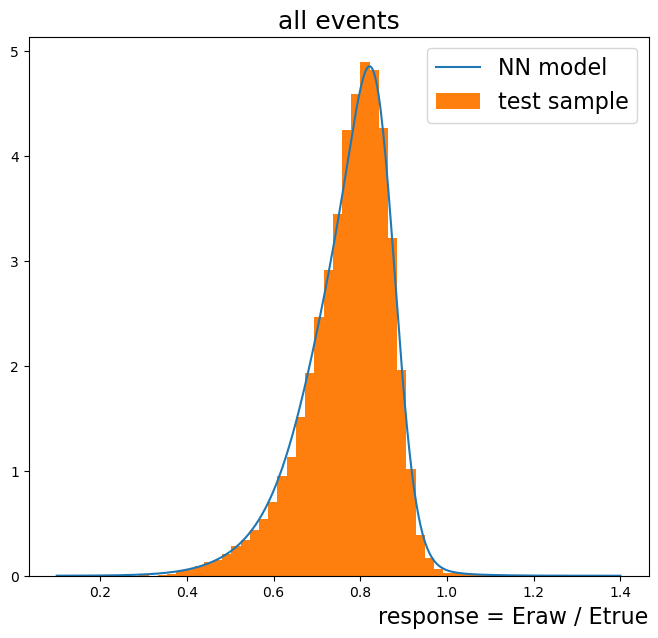

In [173]:
xspace = np.linspace(0.1, 1.4, 500)

ysum = get_pdf_from_dataframe(df_test, xspace)

fig, ax = plt.subplots(figsize=(8, 7))
ax.plot(xspace, ysum / len(df_test), label='NN model')
ax.hist(df_test[column_y], bins=50, density=True, label='test sample')
ax.legend(loc=0, fontsize=16)
ax.set_xlabel('response = Eraw / Etrue', fontsize=16, loc='right')
ax.set_title('all events', fontsize=18)
plt.show()
fig.savefig('comparison.pdf', bbox_inches='tight')

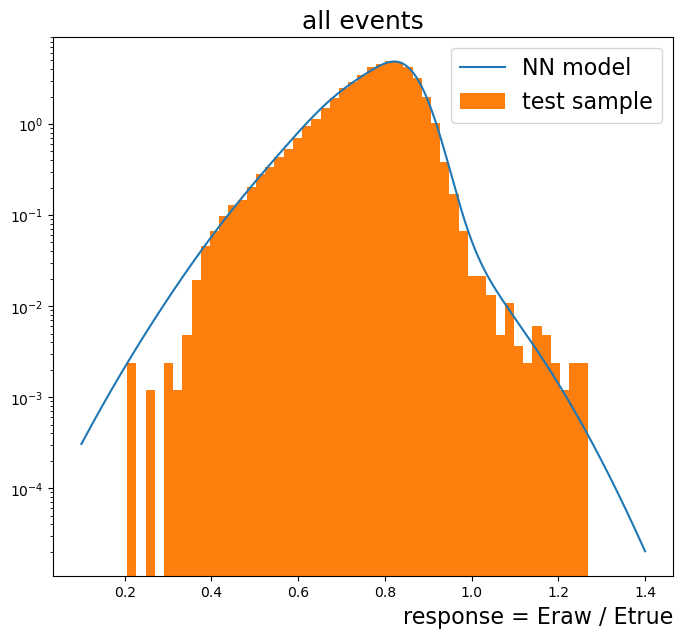

In [174]:
ax.set_yscale('log')  # look at the tails, quite well modelled
fig.savefig('comparison_log.pdf', bbox_inches='tight')
fig

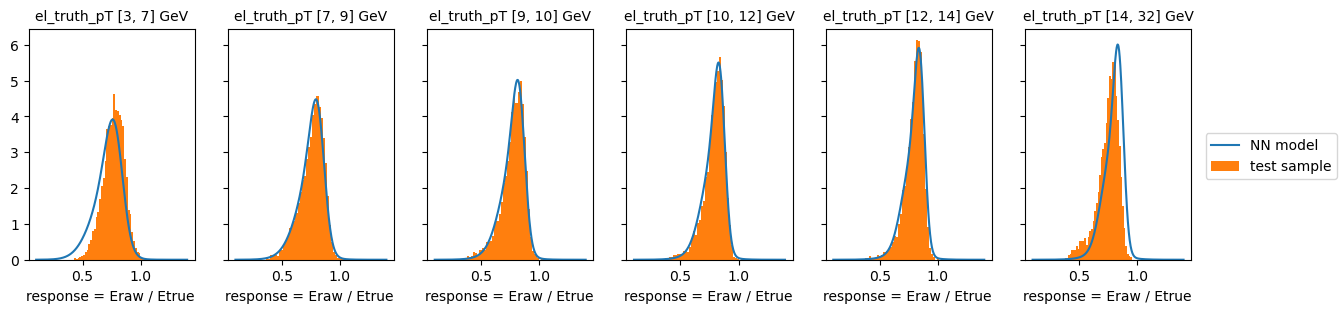

In [234]:
nbins_pt = 6
pt_bins = df_test['el_truth_pT'].quantile(np.linspace(0, 1, nbins_pt + 1)).values
xspace = np.linspace(0.1, 1.4, 500)

fig, axs = plt.subplots(1, nbins_pt, figsize=(15, 3), sharey=True)
for ptbin, df_ptbin in df_test.groupby(np.digitize(df_test['el_truth_pT'], pt_bins)):
    ptbin = int(ptbin)
    if ptbin <= 0 or ptbin > nbins_pt:
        continue
    ysum = get_pdf_from_dataframe(df_ptbin, xspace)    
    ax = axs[ptbin - 1]
    p1 = ax.plot(xspace, ysum / len(df_ptbin), label='NN model')
    p2 = ax.hist(df_ptbin[column_y], bins=50, density=True, label='test sample')
    ax.set_xlabel('response = Eraw / Etrue', fontsize=10, loc='right')
    ax.set_title('el_truth_pT [%.0f, %.0f] GeV' % (pt_bins[ptbin - 1] / 1E3, pt_bins[ptbin] / 1E3), fontsize=10)
fig.legend(['NN model', 'test sample'], loc=7)
fig.subplots_adjust(right=0.9)

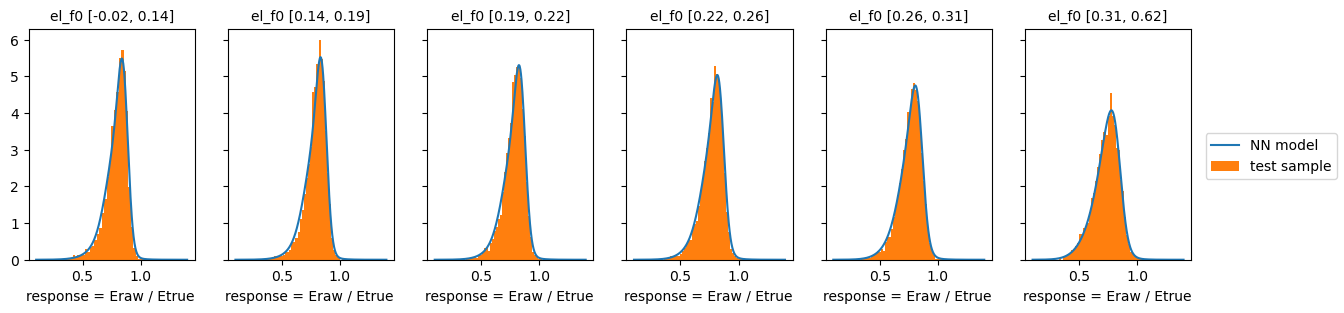

In [232]:
nbins_f0 = 6
f0_bins = df_test['el_f0'].quantile(np.linspace(0, 1, nbins_f0 + 1)).values
xspace = np.linspace(0.1, 1.4, 500)

fig, axs = plt.subplots(1, nbins_f0, figsize=(15, 3), sharey=True)
for f0bin, df_f0bin in df_test.groupby(np.digitize(df_test['el_f0'], f0_bins)):
    f0bin = int(f0bin)
    if f0bin <= 0 or f0bin > nbins_f0:
        continue
    ysum = get_pdf_from_dataframe(df_f0bin, xspace)    
    ax = axs[f0bin - 1]
    ax.plot(xspace, ysum / len(df_f0bin), label='NN model')
    ax.hist(df_f0bin[column_y], bins=50, density=True, label='test sample')
    ax.set_xlabel('response = Eraw / Etrue', fontsize=10, loc='right')
    ax.set_title('el_f0 [%.2f, %.2f]' % (f0_bins[f0bin - 1], f0_bins[f0bin]), fontsize=10)
fig.legend(['NN model', 'test sample'], loc=7)
fig.subplots_adjust(right=0.9)

## Resolution estimation
We are able to estimate the resolution event by event! Check it differentially as a function of the input variables. Not perfect, but it is able to get the features.

Note how smooth is the NN

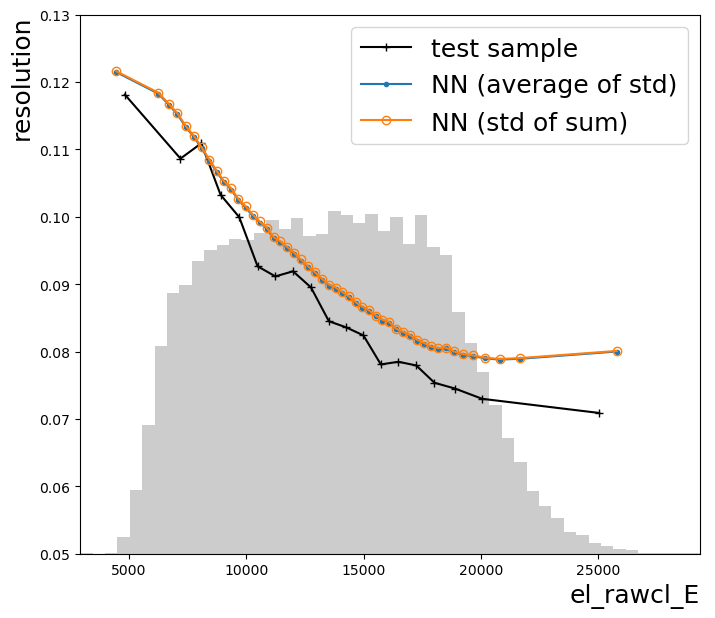

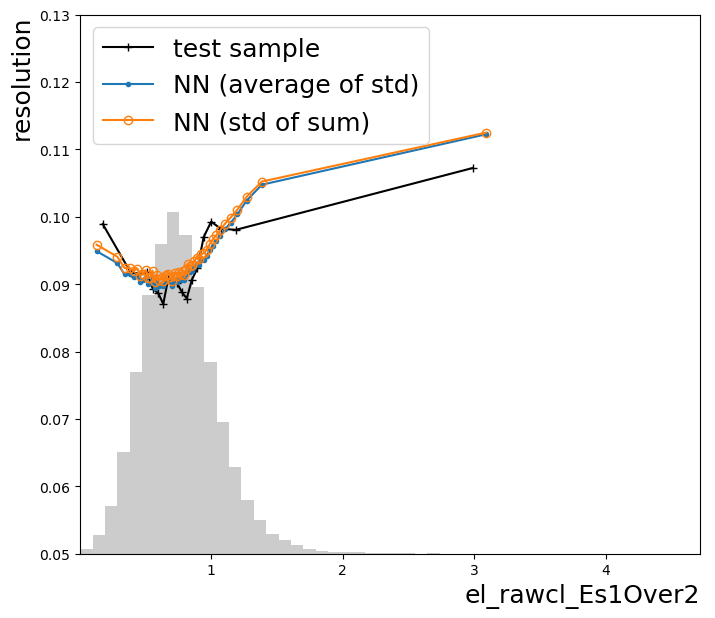

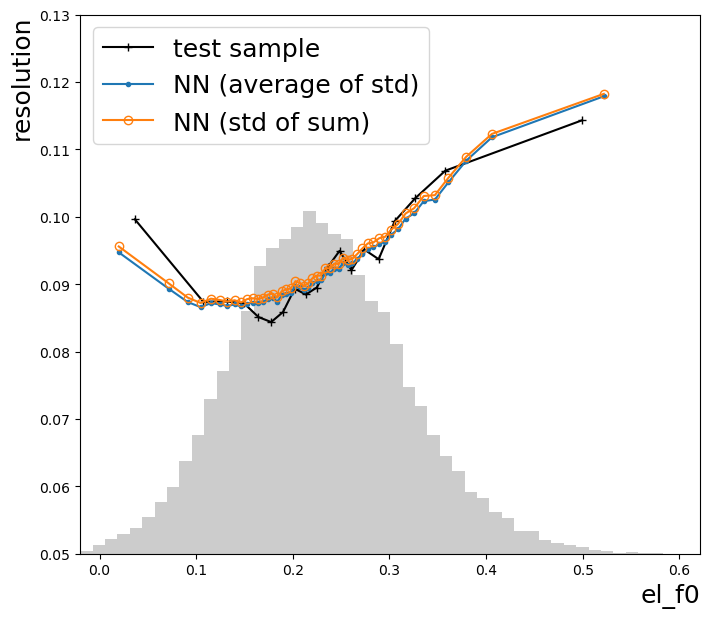

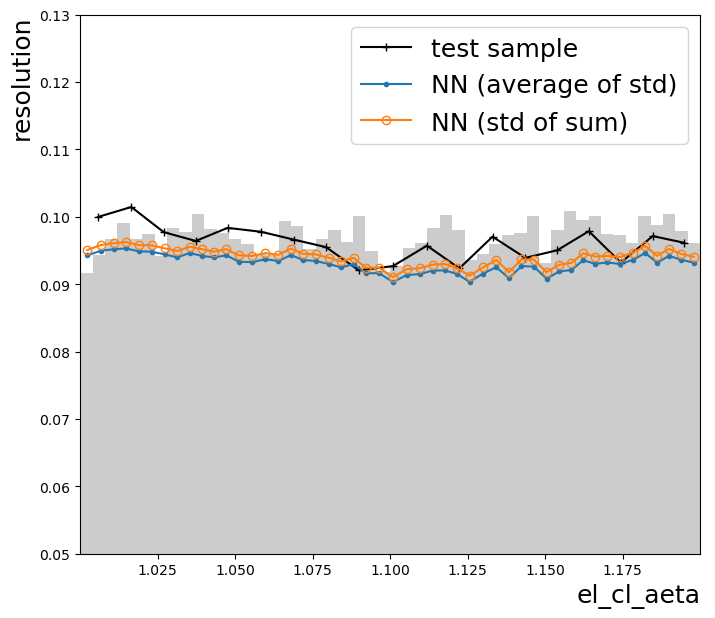

In [170]:
def get_profile(df, xvar, energy_var, xedges, estimators=('median', 'sem')):
    df_agg = df_test.groupby(np.digitize(df_test[xvar], xedges)).apply(
        # approximate the error of the median as the standard error on the mean (sem)
        lambda df: (df[energy_var] / df['el_truth_E']).apply(estimators))
    df_agg = df_agg.reindex(range(1, len(xedges)))
    xmidpoints = 0.5 * (xedges[1:] + xedges[:-1])
    df_agg.index = xmidpoints
    return df_agg

for xvar in columns_X:
    xedges = df_test[xvar].quantile(np.linspace(0, 1, 20)).values

    fig, ax = plt.subplots(figsize=(8, 7))

    df_agg1 = get_profile(df_test, xvar, 'el_rawcl_E', xedges, ('std',) )
    ax.plot(df_agg1.index, df_agg1.values, 'k+-', label='test sample')

    xedges = df_test[xvar].quantile(np.linspace(0, 1, 50)).values
    df_agg2 = df_test.groupby(np.digitize(df_test[xvar], xedges))['NN_std'].mean()
    df_agg2 = df_agg2.reindex(range(1, len(xedges)))
    ax.plot(0.5 * (xedges[1:] + xedges[:-1]), df_agg2.values, '.-', label='NN (average of std)')

    df_agg3 = df_test.groupby(np.digitize(df_test[xvar], xedges)).apply(get_variance_mixture)
    df_agg3 = np.sqrt(df_agg3.reindex(range(1, len(xedges))))
    ax.plot(0.5 * (xedges[1:] + xedges[:-1]), df_agg3.values, 'o-', fillstyle='none', label='NN (std of sum)')

    
    ax.legend(fontsize=18)
    ax.set_xlabel(xvar, fontsize=18, loc='right')
    ax.set_ylabel('resolution', fontsize=18, loc='top')
    ax.set_ylim(0.05, 0.13)
    
    ax2 = ax.twinx()
    ax2.hist(df_test[xvar], 50, color='0.8', density=True)
    ax2.set_ylim(0, ax2.get_ylim()[1] * 1.5)
    ax2.set_yticks([])
    
    ax.set_zorder(ax2.get_zorder() + 1)
    ax.set_frame_on(False)
    ax.set_xlim(xedges[0], xedges[-1])
    plt.show()
    fig.savefig('resolution_vs_%s.pdf' % xvar, bbox_inches='tight')

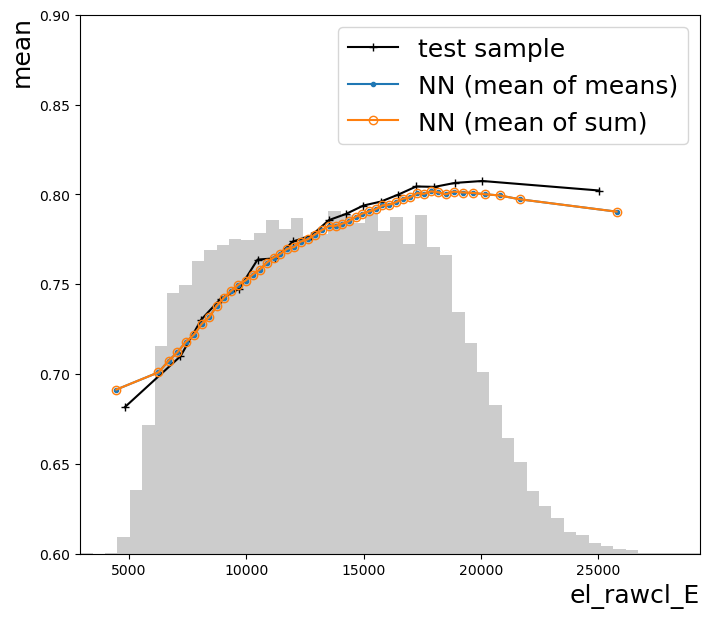

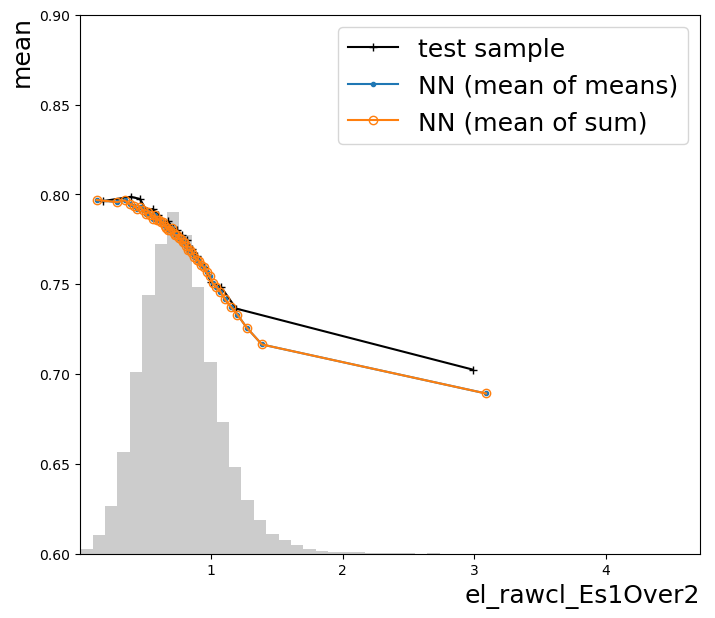

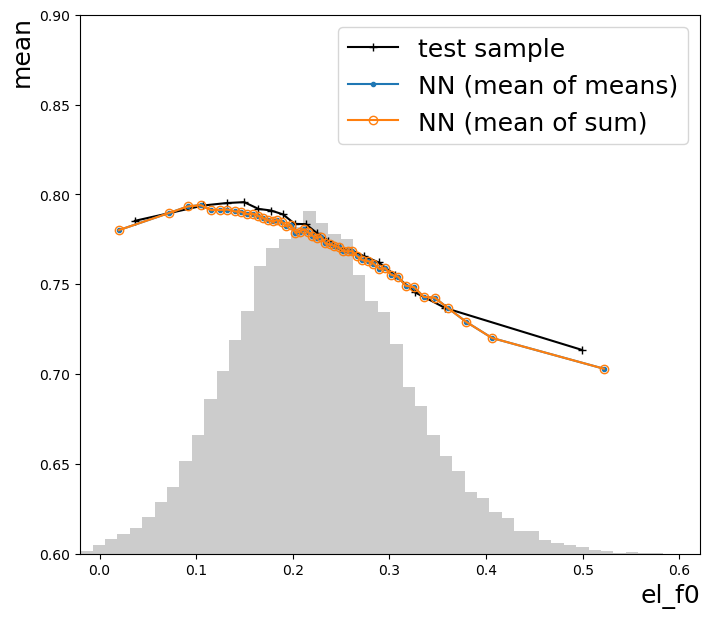

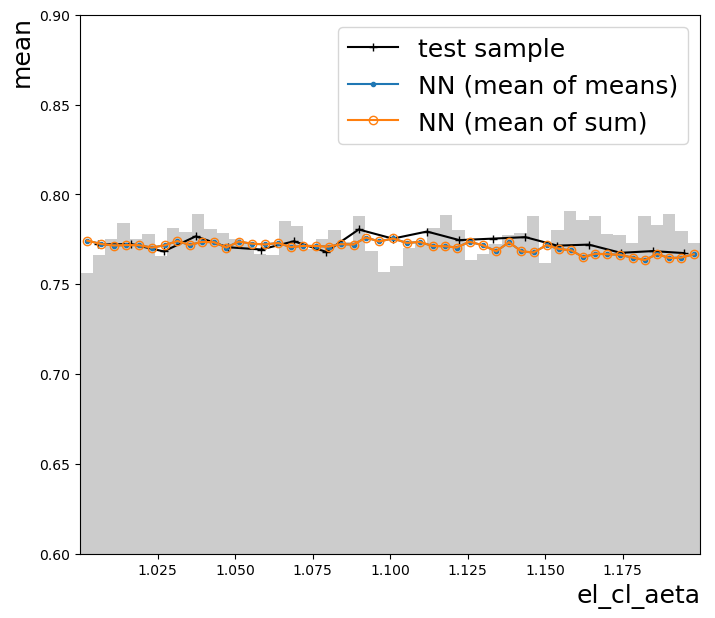

In [171]:
for xvar in columns_X:
    xedges = df_test[xvar].quantile(np.linspace(0, 1, 20)).values

    fig, ax = plt.subplots(figsize=(8, 7))

    df_agg1 = get_profile(df_test, xvar, 'el_rawcl_E', xedges, ('mean',) )
    ax.plot(df_agg1.index, df_agg1.values, 'k+-', label='test sample')

    xedges = df_test[xvar].quantile(np.linspace(0, 1, 50)).values
    df_agg2 = df_test.groupby(np.digitize(df_test[xvar], xedges))['NN_mean'].mean()
    df_agg2 = df_agg2.reindex(range(1, len(xedges)))
    ax.plot(0.5 * (xedges[1:] + xedges[:-1]), df_agg2.values, '.-', label='NN (mean of means)')

    df_agg3 = df_test.groupby(np.digitize(df_test[xvar], xedges)).apply(get_mean_mixture)
    df_agg3 = df_agg3.reindex(range(1, len(xedges)))
    ax.plot(0.5 * (xedges[1:] + xedges[:-1]), df_agg3.values, 'o-', fillstyle='none', label='NN (mean of sum)')

    ax.legend(fontsize=18)
    ax.set_xlabel(xvar, fontsize=18, loc='right')
    ax.set_ylabel('mean', fontsize=18, loc='top')
    ax.set_ylim(0.60, 0.90)
    
    ax2 = ax.twinx()
    ax2.hist(df_test[xvar], 50, color='0.8', density=True)
    ax2.set_ylim(0, ax2.get_ylim()[1] * 1.5)
    ax2.set_yticks([])
    
    ax.set_zorder(ax2.get_zorder() + 1)
    ax.set_frame_on(False)
    ax.set_xlim(xedges[0], xedges[-1])
    plt.show()
    fig.savefig('scale_vs_%s.pdf' % xvar, bbox_inches='tight')

## Estimate the best energy
For each event we can estimate the best energy

   * for comparison, the raw energy scaled by the  median response (evaluated on the test dataset)
   * using as correction the mean of the estimated distribution
   * using as correction the mean of the largest component of the estimated distribution (as an approximation of the mode)

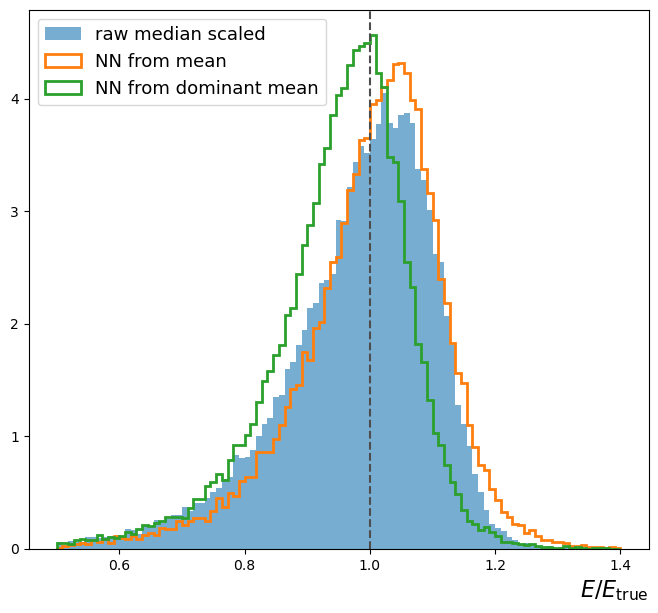

In [172]:
dominant_component = int(np.median(alphas.argmax(axis=1)))

fig, ax = plt.subplots(figsize=(8, 7))
bins = np.linspace(0.5, 1.4, 100)

ax.hist(df_test['el_rawcl_E'] / df_test['el_erawOverEtrue'].median() / df_test['el_truth_E'], label='raw median scaled', bins=bins, density=True, alpha=0.6)

correction_mean = yhat.mean().numpy().flatten()
ax.hist(df_test['el_rawcl_E'] / correction_mean / df_test['el_truth_E'], label='NN from mean', bins=bins, density=True, histtype='step', lw=2)

correction_dominant_mean = yhat.components_distribution.mean().numpy()[:, dominant_component, 0]
ax.hist(df_test['el_rawcl_E'] / correction_dominant_mean / df_test['el_truth_E'], label='NN from dominant mean', bins=bins, density=True, histtype='step', lw=2)

ax.axvline(1, ls='--', color='0.3')
ax.legend(loc=2, fontsize=13)
ax.set_xlabel(r'$E / E_\mathrm{true}$', fontsize=16, loc='right')
plt.show()
fig.savefig('final_comparison.pdf', bbox_inches='tight')